In [2]:
# Import all libraries here
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols
import plotly.express as px
import plotly.graph_objects as go

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')


In [3]:
# Open the cleaned datasets from the cleaned_datasets folder
movies = pd.read_csv('cleaned_datasets/movies_clean.csv')
characters = pd.read_csv('cleaned_datasets/characters_clean.csv')
actors_info = pd.read_csv('cleaned_datasets/actors_info_clean.csv')
actors_list = pd.read_csv('cleaned_datasets/actors_list_clean.csv')

# How awards influence the movies?

For this, let's try to first see some general trends by plotting movies with nonimated cast and those without.

In [4]:
# Add the average fame, liked, disliked and neutral scores from the characters dataframe per movie to the movies dataframe
values = characters.groupby('freebase_movie_id',as_index=False).mean()#.agg({'Fame':'mean','Liked':'mean','Disliked':'mean','Neutral':'mean'})
movies = pd.merge(movies, values[['freebase_movie_id','Fame','Liked','Disliked','Neutral']], left_on='freebase_id', right_on='freebase_movie_id', how='left')
movies = movies.drop(['freebase_movie_id'], axis=1)
movies.head()

,wikipedia_id,freebase_id,name,release_date,revenue,runtime,languages,countries,genres,year_release,averageRating,numVotes,average_award_cumcount,average_movies_cumcount,award_cumcount,movies_cumcount,Fame,Liked,Disliked,Neutral
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",2001,4.9,56894.0,0.0,4.529412,0.0,77.0,13.705882,9.117647,1.117647,3.411765
1,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D...",1988,5.6,40.0,0.0,0.500000,0.0,2.0,0.000000,0.000000,0.000000,0.000000
2,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}",1983,5.9,623.0,0.0,1.666667,0.0,5.0,0.000000,0.000000,0.000000,0.000000
3,13696889,/m/03cfc81,The Gangsters,1913-05-29,NaN,35,"{""/m/06ppq"": ""Silent film"", ""/m/02h40lc"": ""Eng...","{""/m/09c7w0"": ""United States of America""}","{""/m/02hmvc"": ""Short Film"", ""/m/06ppq"": ""Silen...",1913,6.8,16.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000
4,10408933,/m/02qc0j7,Alexander's Ragtime Band,1938-08-16,3600000.0,106,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/04t36"": ""Musical"", ""/m/01z4y"": ""Comedy"", ...",1938,6.8,2268.0,0.0,3.750000,0.0,15.0,15.250000,9.000000,1.250000,4.750000


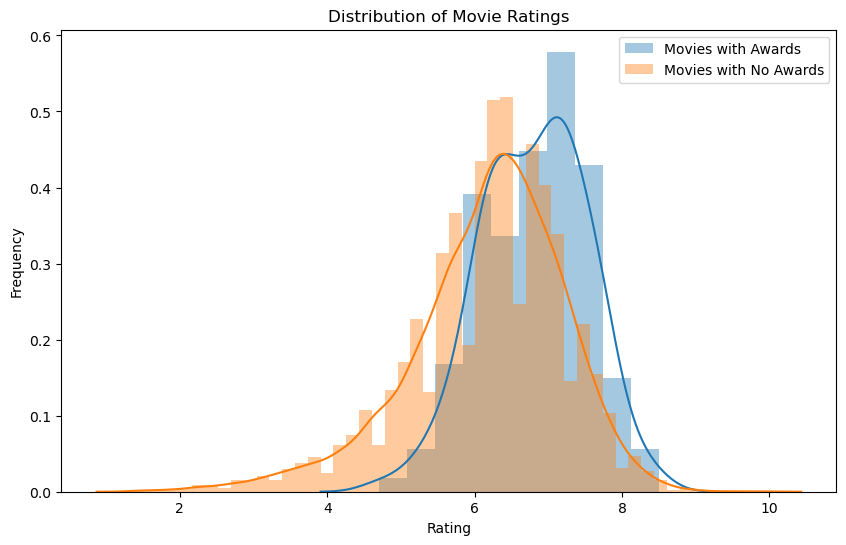

In [98]:
# Split the movies into two dataframes, one for the movies that have an award cumcount and one for the movies with no awards
movies_awards = movies[movies['award_cumcount'] > 10]
movies_no_awards = movies[movies['award_cumcount'] <= 10]

# Plot the ratings distribution for movies both movies with and without awards on the same plot
plt.figure(figsize=(10,6))
sns.distplot(movies_awards['averageRating'], label='Movies with Awards')
sns.distplot(movies_no_awards['averageRating'], label='Movies with No Awards')
plt.title('Distribution of Movie Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.legend()

As we can see, with out first look it seems like the distribution of ratings is pretty similar between both groups.

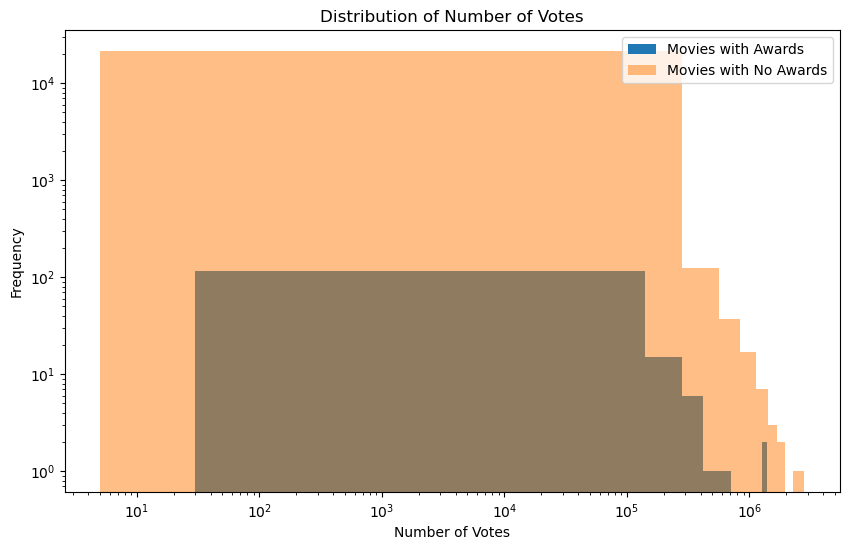

In [99]:
# Lets now look at the distribution of the number of votes for both types of movies using a histogram
plt.figure(figsize=(10,6))
plt.hist(movies_awards['numVotes'], label='Movies with Awards')
plt.hist(movies_no_awards['numVotes'], label='Movies with No Awards', alpha=0.5)
plt.title('Distribution of Number of Votes')
plt.xlabel('Number of Votes')
plt.xscale('log')
plt.yscale('log')
plt.ylabel('Frequency')
plt.legend()

As we can see, the awarded casts produced movies with a much higher number of votes, maybe having a high number of votes increases your rating?

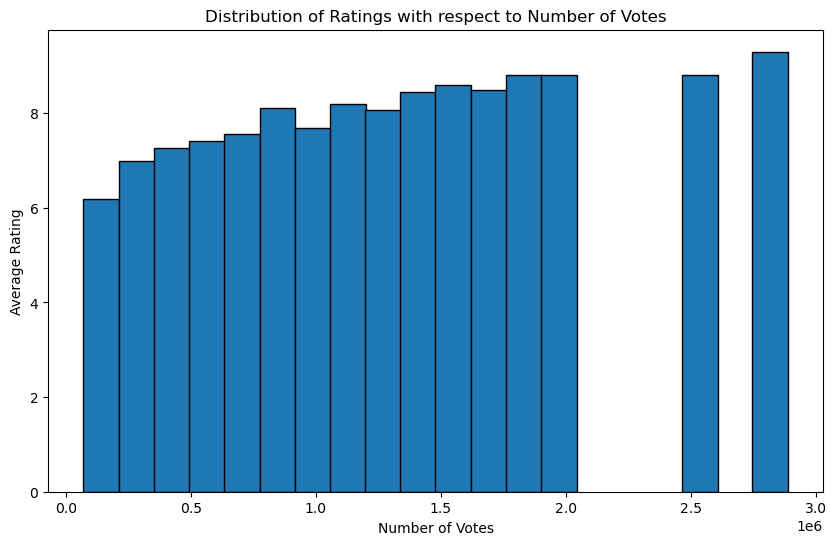

In [100]:
# Lets now look at the distribution of the number of votes per rating for both types of movies using a histogram

# Calculate the mean of 'averageRating' for each bin
bin_means = movies.groupby(pd.cut(movies['numVotes'], bins=20))['averageRating'].mean()
bin_midpoints = [(bin.left + bin.right) / 2 for bin in bin_means.index]
bin_width = bin_means.index[1].left - bin_means.index[0].left

# Plotting the histogram with mean values
plt.figure(figsize=(10,6))
plt.bar(bin_midpoints, bin_means.values, edgecolor='black', align='edge', width=bin_width)

# Adding labels and title
plt.xlabel('Number of Votes')
plt.ylabel('Average Rating')
plt.title('Distribution of Ratings with respect to Number of Votes')

# Show the plot
plt.show()


Looks like a trend!

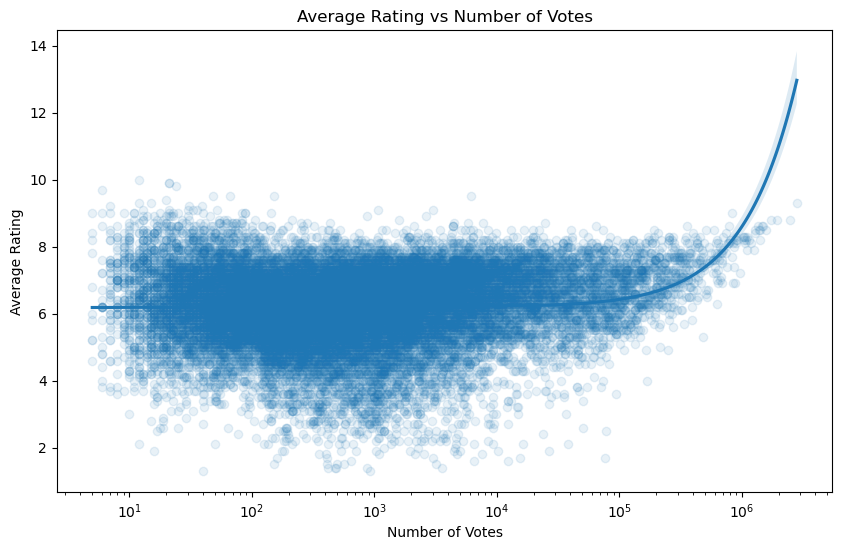

In [101]:
# Lets now do a regression plot of the average rating vs the number of votes for both types of movies
plt.figure(figsize=(10,6))
sns.regplot(x='numVotes', y='averageRating', data=movies,scatter_kws={'alpha':0.1})
# Make the scatter points more transparent so we can see the density of the points
plt.title('Average Rating vs Number of Votes')
plt.xlabel('Number of Votes')
plt.ylabel('Average Rating')
plt.xscale('log')

In [102]:
# Probably would be nice to normalize the number of votes
# TODO check regression with awards and without awards, see if the difference is significant

# Ols regression of ratings vs log(number of votes) for movies
model = ols('averageRating ~ np.log(numVotes)', movies).fit()
print(model.summary())

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
                            OLS Regression Results                            
Dep. Variable:          averageRating   R-squared:                       0.013
Model:                            OLS   Adj. R-squared:                  0.013
Method:                 Least Squares   F-statistic:                     341.5
Date:                Fri, 15 Dec 2023   Prob (F-statistic):           9.61e-76
Time:                        20:10:50   Log-Likelihood:                -37831.
No. Observations:               25515   AIC:                         7.567e+04
Df Residuals:                   25513   BIC:                         7.568e+04
Df Model:                           1                                         
Covariance Type:            nonrobust  

# Time Analysis of awards

In [103]:
import plotly.express as px
import plotly.graph_objs as go
from ipywidgets import widgets, VBox

# Because the dataset of awards starts at year 1927
award_df = movies[movies['year_release'].astype(int)>= 1926]
award_df.dropna(subset=['award_cumcount'], inplace=True)
print(len(award_df))

21164


In [104]:
fig = px.histogram(award_df, x='numVotes', nbins=50, title='Distribution of Number of Votes')

# Update layout if needed
fig.update_layout(
    xaxis_title='Number of Votes',
    yaxis_title='Count of Movies',
    bargap=0.2  # Gap between bars
)

# Show the plot
fig.show()

print(len(award_df[award_df['numVotes']>=500]))

12796


As seen here, we have a huge amount of movies that have really low numbers of votes. This will lead to false conslusion as a movie with 10 votes and a high rating will be compared in our analysis to movies with more than 100k votes. Therefore, we chose the threshold of 500 votes, so we now consider a dataset of 13'480 movies.

In [105]:
award_df = award_df[award_df['numVotes'] >= 2000]

In [106]:
f = go.FigureWidget(
    data=[{
        'type': 'scatter',
        'mode': 'markers',
        'marker': {'size': 10, 'opacity': 0.8, 'line': {'width': 2}}
    }], 
    layout={
        'height': 400  # Adjust the height of the plot here
    }
)

# Function to plot with Plotly
def plot_awards_ratings(year):
    # Filter the dataframe for the selected year
    data_year = award_df[award_df['year_release'] == year]

    # Update the scatter plot with the new data
    f.data[0].x = data_year['award_cumcount']
    f.data[0].y = data_year['averageRating']
    f.data[0].text = data_year['name'] + '<br>Votes: ' + data_year['numVotes'].astype(str) + '<br>Rating: ' + data_year['averageRating'].astype(str)

    f.data[0].hoverinfo = 'text'  # Show hover text with movie names

    # Update layout
    f.update_layout(
        title=f'Movie Ratings and Awards Count in {year}',
        xaxis={'title': 'Number of Awards'},
        yaxis={'title': 'IMDb Rating'}
    )

# Slider widget for year selection
year_slider = widgets.IntSlider(
    value=award_df['year_release'].min(),
    min=award_df['year_release'].min(),
    max=award_df['year_release'].max(),
    step=1,
    description='Select Year:',
    continuous_update=True,
    layout=widgets.Layout(width='50%', margin='0 auto 0 auto')
)

# Create the interactive widget
interactive_widget = widgets.interactive(plot_awards_ratings, year=year_slider)

VBox((f, interactive_widget))

    'data': [{'marker': {'line': {'width': 2}, 'opacity': 0.8, 'size': 10},
    …

In [107]:
import ast  # for safely evaluating strings as Python expressions
import matplotlib.pyplot as plt

# Create a copy of the DataFrame for this operation
analysis_df = award_df.copy()

# Safely convert string representations of dictionaries to actual dictionaries in the copy
analysis_df['genres'] = analysis_df['genres'].apply(ast.literal_eval)

# Extract genres and count their occurrences
genre_counts = {}
for row in analysis_df['genres']:
    for genre in row.values():
        if genre in genre_counts:
            genre_counts[genre] += 1
        else:
            genre_counts[genre] = 1

# Sort genres by frequency and select the top 20
sorted_genres = dict(sorted(genre_counts.items(), key=lambda item: item[1], reverse=True)[:20])

# Plotting with Plotly
fig = px.bar(x=list(sorted_genres.keys()), y=list(sorted_genres.values()), 
             labels={'x': 'Genres', 'y': 'Frequency'},
             title='Top 20 Genres Distribution',
             color=list(sorted_genres.keys()),
             hover_data={'Frequency': list(sorted_genres.values())})

fig.show()
top_genres = list(sorted_genres)[:5]
fig.write_html('img/genre_distribution.html')

In [108]:
# Function to safely evaluate strings as dictionaries and extract genre names",
def extract_genre_names(genre_string):
    try:
        # Safely evaluate the string as a dictionary",
        genre_dict = ast.literal_eval(genre_string)
        # If the result is a dictionary, return the list of genre names",
        if isinstance(genre_dict, dict):
            return list(genre_dict.values())
    except (ValueError, SyntaxError):
        # In case of an error, return an empty list",
        return []
    
    # If the string was not a dictionary, return an empty list"
    return []

In [109]:
def get_pair(i):
    if i <= 3 :
        row = i
        col = 1
    else:
        row = (i%2) + 1
        col = 2
    return (row, col)

In [110]:
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import pandas as pd
import numpy as np

# Assuming the 'genres' column contains string representations of lists of dictionaries",
award_df['genre_names'] = award_df['genres'].apply(extract_genre_names)
top_genres = [str(element) for element in top_genres]
min_year = award_df['year_release'].min()
max_year = award_df['year_release'].max()

sub = list(["Drama", "Romance Film", "Comedy", "Action", "Thriller"])
# Create subplots\n",
fig = make_subplots(
    rows=3, 
    cols=2,
    specs=[[{}, {}],  # First row with two plots",
           [{}, {}],  # Second row with two plots",
           [{}, None]],  # Two columns in the third row",
    subplot_titles=sub + ['']  # Add empty titles for extra cells",
)

# Update the layout with the desired height and width",
total_height = 150 * len(top_genres)  # Example: 300px per subplot",
fig.update_layout(height=total_height)

# Add a scatter plot for each genre in a different row",
for i, genre in enumerate(top_genres, start=1):
    row, col = get_pair(i)
    genre_df = award_df[(award_df['genre_names'].apply(lambda genres: genre in genres))]
    fig.add_trace(
        go.Scatter(
            x=genre_df['award_cumcount'],
            y=genre_df['averageRating'],
            mode='markers',
            text=genre_df['name'] + '<br>Rating: ' + genre_df['averageRating'].astype(str),  
            hoverinfo='text+name',
            name=str(genre)
        ), 
        row = row,
        col = col

    )

# Update layout for aesthetics",
fig.update_layout(showlegend=False, title_text="IMDB Ratings by Genre and Year")

# Add slider for year selection",
sliders = [dict(
    steps=[dict(method='restyle',
                label=str(year),
                args=[{'x': [award_df[(award_df['year_release'] == year) & (award_df['genre_names'].apply(lambda genres: genre in genres))]['award_cumcount'].tolist() for genre in top_genres],
                       'y': [award_df[(award_df['year_release'] == year) & (award_df['genre_names'].apply(lambda genres: genre in genres))]['averageRating'].tolist() for genre in top_genres]},
                      {'title': f"Data for Year: {year}"}])
           for year in range(min_year, max_year + 1)],
    active=0,
    currentvalue={"prefix": "Year: "},
    pad={"t": 50}
)]

fig.update_layout(sliders=sliders)

# Save to HTML file",
html_file_path = 'img/interactive_genre_subplots.html'
fig.write_html(html_file_path)

In [123]:
import scipy.stats as stats

# Assuming you have filtered_df as the filtered DataFrame
award_cumcount = award_df['award_cumcount']
average_rating = award_df['averageRating']

# Calculate Pearson correlation coefficient and p-value
corr_coeff, p_value = stats.pearsonr(average_rating, award_cumcount)

alpha = 0.05  # Significance level

# Interpret the results
if p_value < alpha:
    print(f"There is a significant correlation (Pearson's r = {corr_coeff:.2f}) between award_cumcount and averageRating.")
else:
    print("There is no significant correlation between award_cumcount and averageRating.")


There is a significant correlation (Pearson's r = 0.14) between award_cumcount and averageRating.


In [151]:
actor_award_movie_df = characters[['actor_name', 'award_cumcount', 'freebase_movie_id']]
actor_award_movie_df.rename(columns={'award_cumcount': 'actor_award_cumcount'}, inplace=True)

# Merge the two DataFrames on the respective columns
merged_df = actor_award_movie_df.merge(award_df, left_on="freebase_movie_id", right_on="freebase_id", how="left")
merged_df = merged_df.drop("freebase_id", axis=1)

# Group the DataFrame by "name" and "award_cumcount" and calculate any aggregate statistics you need
grouped_df = merged_df.groupby(['actor_name', 'actor_award_cumcount']).agg({'averageRating': 'mean'}).reset_index()

# Filter rows based on the specified conditions
grouped_df = grouped_df.groupby('actor_name').filter(lambda group: len(group) > 1 or group['actor_award_cumcount'].max() != 0)

# Filter out actor_award_cumcount values with less than 2 averageRating values
filtered_groups = grouped_df.groupby("actor_award_cumcount").filter(lambda x: len(x) >= 2)

# Calculate the mean of averageRating for each actor_award_cumcount in the filtered groups
trendline_df = filtered_groups.groupby("actor_award_cumcount")["averageRating"].mean().reset_index()

# Assuming you have filtered_df as the filtered DataFrame
fig1 = px.line(
    grouped_df,
    x="actor_award_cumcount",
    y="averageRating",
    line_group="actor_name",  # Group lines by actor_name
    color="actor_name",  # Assign colors based on actor_name
    title="Average Ratings vs. Award Cum Count",
    hover_data={"actor_name": True, "actor_award_cumcount": False, "averageRating": False}
)

# Create subplots with one row and two columns
fig = make_subplots(rows=1, cols=2, shared_yaxes=False)

# Add the original plot to the first column of the subplot
for trace in fig1.data:
    trace.update(showlegend=False)  # Remove legend for each trace
    fig.add_trace(trace, row=1, col=1)

# Add the trendline to the second column of the subplot as before
fig.add_trace(
    go.Scatter(
        x=trendline_df["actor_award_cumcount"],
        y=trendline_df["averageRating"],
        mode="lines",
        line=dict(color="black", width=3),
        showlegend=False
    ),
    row=1, col=2  # Specify the subplot location
)

# Customize the layout of the first plot (fig1)
fig1.update_layout(
    xaxis_title="Award Cum Count",
    yaxis_title="Average Rating",
    xaxis=dict(title_font=dict(size=10), tickfont=dict(size=8)),  
    yaxis=dict(title_font=dict(size=10), tickfont=dict(size=8)),
)

# Customize the layout of the second plot
fig.update_xaxes(
    title_text="Award Cum Count",
    title_font=dict(size=10),  
    tickfont=dict(size=8)  
)
fig.update_yaxes(
    title_text="Average Rating",
    title_font=dict(size=10), 
    tickfont=dict(size=8),  
    range=[4, 9], 
    dtick=1,
)

# Set the height and width of the figure
fig.update_layout(
    height=400,  
    width=1000,  
)

# Show the interactive subplot with both plots side by side
fig.show()
fig.write_html("img/avg_award.html")


AttributeError: type object 'DOMWidget' has no attribute '_ipython_display_'

# Popularity matching

First, let us visualize our data.

In [25]:
# Open the cleaned datasets from the cleaned_datasets folder
movies = pd.read_csv('cleaned_datasets/movies_clean.csv')
characters = pd.read_csv('cleaned_datasets/characters_clean.csv')
actors_info = pd.read_csv('cleaned_datasets/actors_info_clean.csv')
actors_list = pd.read_csv('cleaned_datasets/actors_list_clean.csv')

# Add the average fame, liked, disliked and neutral scores from the characters dataframe per movie to the movies dataframe
values = characters.groupby('freebase_movie_id',as_index=False).mean()#.agg({'Fame':'mean','Liked':'mean','Disliked':'mean','Neutral':'mean'})
movies = pd.merge(movies, values[['freebase_movie_id','Fame','Liked','Disliked','Neutral']], left_on='freebase_id', right_on='freebase_movie_id', how='left')
movies = movies.drop(['freebase_movie_id'], axis=1)

# Check for duplicates in the character dataset
duplicates = characters.duplicated()

# Visualize the duplicated rows
if duplicates.any():
    duplicated_rows = characters[duplicates]
    print("Duplicated Rows:")
    print(duplicated_rows)
else:
    print("No duplicates found in the character dataset.")

    # Check for duplicates in the character dataset
    duplicates = characters.duplicated(subset=['freebase_movie_id', 'actor_name','character_name'], keep=False)

    # Visualize the duplicated rows
    if duplicates.any():
        duplicated_rows = characters[duplicates]
        print("Actors who played multiple roles in the same movie:")
        print(duplicated_rows[['freebase_movie_id', 'actor_name', 'character_name']])
    else:
        print("No actors found who played multiple roles in the same movie.")



# show the NaN charcater names
print(characters[characters['actor_name'].isna()])
#149 cases over 130k, so it doesn't make a difference, I will keep them because I suppose they are correct characters for their movies, so it will represent correctly the size of the cast



# remove the duplicates from the characters dataset
characters = characters.drop_duplicates(subset=['freebase_movie_id', 'actor_name','character_name'], keep='first')

No duplicates found in the character dataset.
Actors who played multiple roles in the same movie:
       freebase_movie_id        actor_name           character_name
10            /m/0cc71m5    Richard Harris  Sheriff Sean Kilpatrick
11            /m/0cc71m5    Richard Harris  Sheriff Sean Kilpatrick
819             /m/0bmpm  Barry Fitzgerald        Father Fitzgibbon
820             /m/0bmpm  Barry Fitzgerald        Father Fitzgibbon
932           /m/0b0k5r_    William Holden            Bill Seacroft
...                  ...               ...                      ...
169305        /m/07kfdtm               NaN                      NaN
169306        /m/07kfdtm               NaN                      NaN
170092        /m/076xyj6               NaN                      NaN
170316         /m/03qfpk      Adam Sandler                      Pip
170317         /m/03qfpk      Adam Sandler                      Pip

[532 rows x 3 columns]
        wikipedia_movie_id freebase_movie_id movie_release_dat

Number of Movies with Fame >65: 41
Number of Movies with Fame <=65: 7061


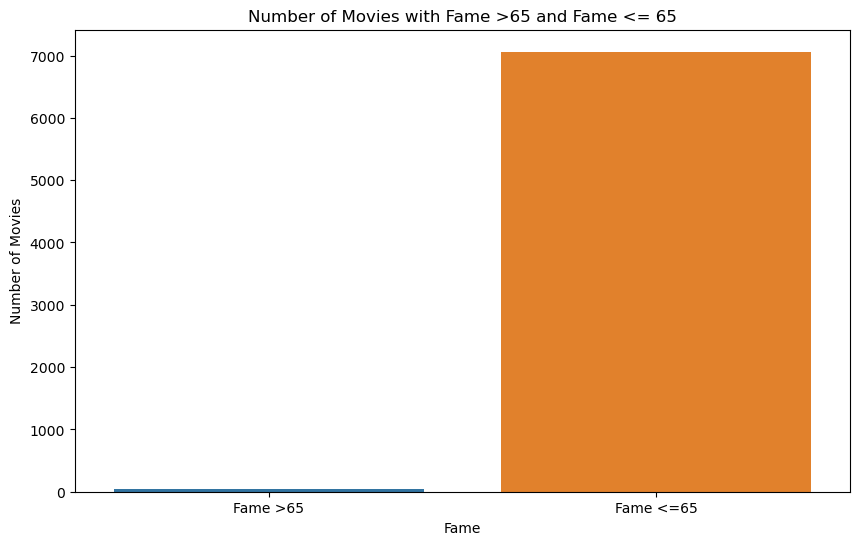

In [26]:
# filter dataset to more restricted movies
movies = movies[movies['numVotes'] >= 2000]
def vis_num(t):
    # plot a bar plot with the movies with a fame > 0 and the movies with a fame = 0, use the number of movies as the height of the bar
    plt.figure(figsize=(10,6))
    sns.barplot(x=['Fame >'+str(t), 'Fame <='+str(t)], y=[len(movies[movies['Fame'] > t]), len(movies[movies['Fame'] <=t])])
    plt.title("Number of Movies with Fame >"+str(t)+" and Fame <= "+ str(t))
    plt.xlabel('Fame')
    plt.ylabel('Number of Movies')
    print("Number of Movies with Fame >"+str(t)+":", len(movies[movies['Fame'] > t]))
    print("Number of Movies with Fame <="+str(t)+":", len(movies[movies['Fame'] <= t]))


vis_num(65)

We add some metrics to have a more complete dataset

In [27]:
#copy of the movies dataframe to prevent to modify the original one
movies_copy = movies.copy()
# add the number of characters per movie to the movies dataframe
characters_per_movie = characters.groupby('freebase_movie_id',as_index=False).agg({'character_name':'size'}).reset_index()
movies_copy = pd.merge(movies_copy, characters_per_movie[['freebase_movie_id','character_name']], left_on='freebase_id', right_on='freebase_movie_id', how='left')
movies_copy = movies_copy.drop(['freebase_movie_id'], axis=1)
movies_copy = movies_copy.rename(columns={'character_name':'num_characters'})

# add the number of actors per movie to the movies dataframe
actors_per_movie = characters.groupby('freebase_movie_id',as_index=False)['actor_name'].nunique()
movies_copy = pd.merge(movies_copy, actors_per_movie[['freebase_movie_id','actor_name']], left_on='freebase_id', right_on='freebase_movie_id', how='left')
movies_copy = movies_copy.drop(['freebase_movie_id'], axis=1)
movies_copy = movies_copy.rename(columns={'actor_name':'num_actors'})

# add the number of actors with fame >0 per movie to the movies dataframe
actors_fame_per_movie = characters[characters['Fame'] > 0].groupby('freebase_movie_id',as_index=False)['actor_name'].nunique()
movies_copy = pd.merge(movies_copy, actors_fame_per_movie[['freebase_movie_id','actor_name']], left_on='freebase_id', right_on='freebase_movie_id', how='left')
movies_copy = movies_copy.drop(['freebase_movie_id'], axis=1)
movies_copy = movies_copy.rename(columns={'actor_name':'num_actors_fame'})

#replace the NaN values with 0 for the number of actors with fame >0
movies_copy['num_actors_fame'] = movies_copy['num_actors_fame'].fillna(0)

# add the fame, liked, disliked and neutral scores from the actors with fame>0 per movie to the movies dataframe
actors_fame_per_movie = characters[characters['Fame'] > 0].groupby('freebase_movie_id',as_index=False).mean()
movies_copy = pd.merge(movies_copy, actors_fame_per_movie[['freebase_movie_id','Fame','Liked','Disliked','Neutral']], left_on='freebase_id', right_on='freebase_movie_id', how='left')
movies_copy = movies_copy.drop(['freebase_movie_id'], axis=1)

#rename the columns to avoid confusion
movies_copy = movies_copy.rename(columns={'Fame_y':'fame_only','Liked_y':'liked_only','Disliked_y':'disliked_only','Neutral_y':'neutral_only'})
movies_copy = movies_copy.rename(columns={'Fame_x':'Fame','Liked_x':'Liked','Disliked_x':'Disliked','Neutral_x':'Neutral'})


#replace the NaN values with 0 for the fame_only, liked_only, disliked_only and neutral_only scores
movies_copy['fame_only'] = movies_copy['fame_only'].fillna(0)
movies_copy['liked_only'] = movies_copy['liked_only'].fillna(0)
movies_copy['disliked_only'] = movies_copy['disliked_only'].fillna(0)
movies_copy['neutral_only'] = movies_copy['neutral_only'].fillna(0)

# add a ratio column with the ratio of actors with fame>0 over the total number of actors per movie
movies_copy['fame_ratio'] = movies_copy['num_actors_fame'] / movies_copy['num_actors']

import json
# extract the genres, the country and the language from the json structures in the columns

def extract_country(row):
    data = json.loads(row['countries'])
    return list(data.values())

def extract_language(row):
    data = json.loads(row['languages'])
    return list(data.values())

def extract_genre(row):
    data = json.loads(row['genres'])
    return list(data.values())

movies_copy['languages'] = movies_copy.apply(extract_language, axis=1)
movies_copy['countries'] = movies_copy.apply(extract_country, axis=1)
movies_copy['genres'] = movies_copy.apply(extract_genre, axis=1)

display(movies_copy.head())

,wikipedia_id,freebase_id,name,release_date,revenue,runtime,languages,countries,genres,year_release,averageRating,numVotes,average_award_cumcount,average_movies_cumcount,award_cumcount,movies_cumcount,Fame,Liked,Disliked,Neutral,num_characters,num_actors,num_actors_fame,fame_only,liked_only,disliked_only,neutral_only,fame_ratio
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",2001,4.9,56894.0,0.000000,4.529412,0.0,77.0,13.705882,9.117647,1.117647,3.411765,17.0,17.0,3.0,77.666667,51.666667,6.333333,19.333333,0.176471
1,10408933,/m/02qc0j7,Alexander's Ragtime Band,1938-08-16,3600000.0,106,[English Language],[United States of America],"[Musical, Comedy, Black-and-white]",1938,6.8,2268.0,0.000000,3.750000,0.0,15.0,15.250000,9.000000,1.250000,4.750000,4.0,4.0,1.0,61.000000,36.000000,5.000000,19.000000,0.250000
2,24229100,/m/07kjkz6,Lady Snowblood 2: Love Song of Vengeance,1974,NaN,89,[Japanese Language],[Japan],"[Crime Fiction, Thriller, Japanese Movies, Wor...",1974,6.3,4078.0,0.000000,1.400000,0.0,7.0,0.000000,0.000000,0.000000,0.000000,5.0,5.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
3,171005,/m/016ywb,Henry V,1989-11-08,10161099.0,137,[English Language],[United Kingdom],"[Costume drama, War film, Epic, Period piece, ...",1989,7.5,31193.0,0.095238,3.047619,2.0,64.0,18.857143,12.666667,1.095238,5.190476,21.0,21.0,6.0,66.000000,44.333333,3.833333,18.166667,0.285714
4,77856,/m/0kcn7,Mary Poppins,1964-08-27,102272727.0,139,[English Language],[United States of America],"[Children's/Family, Musical, Fantasy, Comedy, ...",1964,7.8,181710.0,0.307692,8.000000,4.0,104.0,20.307692,15.846154,0.846154,3.846154,13.0,12.0,2.0,88.000000,68.666667,3.666667,16.666667,0.166667


Now we have the fame and stats for the part of the cast that is considered famous, how many actors we have per movie, and the amount of characters.

Number of Movies with Fame >65: 41
Number of Movies with Fame <=65: 7061


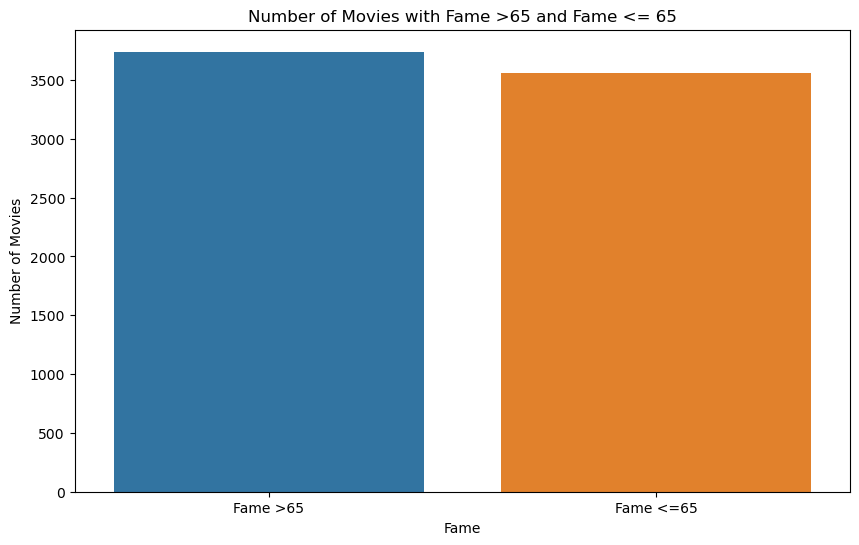

In [28]:
def vis_num2(t):
    # plot a bar plot with the movies with a fame > 0 and the movies with a fame = 0, use the number of movies as the height of the bar
    plt.figure(figsize=(10,6))
    sns.barplot(x=['Fame >'+str(t), 'Fame <='+str(t)], y=[len(movies_copy[movies_copy['fame_only'] > t]), len(movies_copy[movies_copy['fame_only'] <=t])])
    plt.title("Number of Movies with Fame >"+str(t)+" and Fame <= "+ str(t))
    plt.xlabel('Fame')
    plt.ylabel('Number of Movies')
    print("Number of Movies with Fame >"+str(t)+":", len(movies_copy[movies_copy['Fame'] > t]))
    print("Number of Movies with Fame <="+str(t)+":", len(movies_copy[movies_copy['Fame'] <= t]))

vis_num2(65)

In [29]:
from sklearn.preprocessing import MultiLabelBinarizer
movies_reg = movies_copy.copy()

# Flatten the lists of countries and get the top N most frequent countries
top_countries = movies_reg['countries'].explode().value_counts().nlargest(10).index
movies_reg['countries'] = movies_reg['countries'].apply(lambda lst: ['Other' if country not in top_countries else country for country in lst])

# Initialize the MultiLabelBinarizer
mlb = MultiLabelBinarizer()

# Fit and transform the lists of countries
one_hot_encoded = mlb.fit_transform(movies_reg['countries'])

#version with a vector instead of a column for each country
# # Create a single column with a vector representation
#movies_reg['countries_vector'] = one_hot_encoded.tolist()

# # Drop the original 'countries_column' and the one-hot encoded columns
# df = df.drop(['countries'], axis=1)

# Create a DataFrame with the one-hot encoded values
one_hot_df = pd.DataFrame(one_hot_encoded, columns=mlb.classes_)

# Concatenate the original DataFrame with the one-hot encoded DataFrame
movies_reg = pd.concat([movies_reg, one_hot_df], axis=1)

# do the same for the languages
top_languages = movies_reg['languages'].explode().value_counts().nlargest(10).index
movies_reg['languages'] = movies_reg['languages'].apply(lambda lst: ['Other' if language not in top_languages else language for language in lst])

# Initialize the MultiLabelBinarizer
mlb = MultiLabelBinarizer()
# Fit and transform the lists of languages
one_hot_encoded = mlb.fit_transform(movies_reg['languages'])
#vector version
#movies_reg['languages_vector'] = one_hot_encoded.tolist()
# Create a DataFrame with the one-hot encoded values
one_hot_df = pd.DataFrame(one_hot_encoded, columns=mlb.classes_)
# Concatenate the original DataFrame with the one-hot encoded DataFrame
movies_reg = pd.concat([movies_reg, one_hot_df], axis=1)

# do the same for the genres
top_genres = movies_reg['genres'].explode().value_counts().nlargest(10).index
movies_reg['genres'] = movies_reg['genres'].apply(lambda lst: ['Other' if genre not in top_genres else genre for genre in lst])
# Initialize the MultiLabelBinarizer
mlb = MultiLabelBinarizer()
# Fit and transform the lists of genres
one_hot_encoded = mlb.fit_transform(movies_reg['genres'])
#vector version
#movies_reg['genres_vector'] = one_hot_encoded.tolist()
# Create a DataFrame with the one-hot encoded values
one_hot_df = pd.DataFrame(one_hot_encoded, columns=mlb.classes_)
# Concatenate the original DataFrame with the one-hot encoded DataFrame
movies_reg = pd.concat([movies_reg, one_hot_df], axis=1)

pd.set_option('display.max_columns', None)
# display(movies_reg.head())

#replace the NaN values with 0
movies_reg = movies_reg.fillna(0)

#create a new column with a dummy variable if fame >0
movies_reg['fame_dummy'] = movies_reg['Fame'].apply(lambda x: 1 if x > 75 else 0)

# Propensity scores:

Now we compute the likelihood for a cast to be famous or not

In [30]:
from sklearn.linear_model import LogisticRegression

# Select the relevant features for the logistic regression model, and all the one-hot encoded columns
# features when using all the the movies
#features = ['numVotes', 'award_cumcount', 'movies_cumcount', 'num_actors', 'Australia', 'Canada', 'France', 'Germany', 'India', 'Italy', 'Japan', 'Other', 'South Korea', 'United Kingdom', 'United States of America', 'English Language', 'French Language', 'German Language', 'Hindi Language', 'Italian Language', 'Japanese Language', 'Korean Language', 'Other', 'Silent film', 'Spanish Language', 'Standard Mandarin', 'Action', 'Black-and-white', 'Comedy', 'Crime Fiction', 'Drama', 'Indie', 'Other', 'Romance Film', 'Short Film', 'Thriller', 'World cinema']
# features when using only the movies with numVotes >= 2000
features = ['numVotes', 'award_cumcount', 'movies_cumcount', 'num_actors', 'Australia', 'Canada', 'France', 'Germany', 'India', 'Italy', 'Japan', 'Other', 'Spain', 'United Kingdom', 'United States of America', 'English Language', 'French Language', 'German Language', 'Hindi Language', 'Italian Language', 'Japanese Language', 'Russian Language', 'Other', 'Swedish Language', 'Spanish Language', 'Standard Mandarin', 'Action', 'Action/Adventure', 'Comedy', 'Crime Fiction', 'Drama', 'Indie', 'Other', 'Romance Film', 'Horror', 'Thriller', 'World cinema']

# Create the feature matrix X and the target variable y
X = movies_reg[features]
y = movies_reg['fame_dummy']

# Fit the logistic regression model
model = LogisticRegression()
model.fit(X, y)

# Compute the propensity scores
propensity_scores = model.predict_proba(X)[:, 1]

# Add the propensity scores to the movies_copy dataset
movies_copy['propensity_score'] = propensity_scores

pd.set_option('display.max_columns', None)
movies_copy.head()


,wikipedia_id,freebase_id,name,release_date,revenue,runtime,languages,countries,genres,year_release,averageRating,numVotes,average_award_cumcount,average_movies_cumcount,award_cumcount,movies_cumcount,Fame,Liked,Disliked,Neutral,num_characters,num_actors,num_actors_fame,fame_only,liked_only,disliked_only,neutral_only,fame_ratio,propensity_score
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",2001,4.9,56894.0,0.000000,4.529412,0.0,77.0,13.705882,9.117647,1.117647,3.411765,17.0,17.0,3.0,77.666667,51.666667,6.333333,19.333333,0.176471,8.797486e-09
1,10408933,/m/02qc0j7,Alexander's Ragtime Band,1938-08-16,3600000.0,106,[English Language],[United States of America],"[Musical, Comedy, Black-and-white]",1938,6.8,2268.0,0.000000,3.750000,0.0,15.0,15.250000,9.000000,1.250000,4.750000,4.0,4.0,1.0,61.000000,36.000000,5.000000,19.000000,0.250000,1.744854e-03
2,24229100,/m/07kjkz6,Lady Snowblood 2: Love Song of Vengeance,1974,NaN,89,[Japanese Language],[Japan],"[Crime Fiction, Thriller, Japanese Movies, Wor...",1974,6.3,4078.0,0.000000,1.400000,0.0,7.0,0.000000,0.000000,0.000000,0.000000,5.0,5.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,4.447250e-04
3,171005,/m/016ywb,Henry V,1989-11-08,10161099.0,137,[English Language],[United Kingdom],"[Costume drama, War film, Epic, Period piece, ...",1989,7.5,31193.0,0.095238,3.047619,2.0,64.0,18.857143,12.666667,1.095238,5.190476,21.0,21.0,6.0,66.000000,44.333333,3.833333,18.166667,0.285714,3.298206e-10
4,77856,/m/0kcn7,Mary Poppins,1964-08-27,102272727.0,139,[English Language],[United States of America],"[Children's/Family, Musical, Fantasy, Comedy, ...",1964,7.8,181710.0,0.307692,8.000000,4.0,104.0,20.307692,15.846154,0.846154,3.846154,13.0,12.0,2.0,88.000000,68.666667,3.666667,16.666667,0.166667,1.668535e-06


In [31]:
from causalml.match import NearestNeighborMatch 

# add dummy variable for fame_only >0 in the movies_copy dataframe
movies_copy['fame_dummy'] = movies_reg['fame_dummy']

# Initialize Matching
matcher = NearestNeighborMatch()

#match the data with the propensity scores as the y column and use one element from each dataset to make a pair, use NearestNeighborMatch() to match the pairs
matched_pairs = matcher.match(data=movies_copy, treatment_col='fame_dummy', score_cols=['propensity_score'])

# make a dataframe with only the fame_dummy = 0 elements of the matched pairs
df_zero = matched_pairs[matched_pairs['fame_dummy'] == 0]
# make a dataframe with only the fame_dummy = 1 elements of the matched pairs
df_positive = matched_pairs[matched_pairs['fame_dummy'] == 1]

# check the number of elements in each dataframe
print(len(df_zero))
print(len(df_positive))




15
15


Let's see how the matched pairs work!

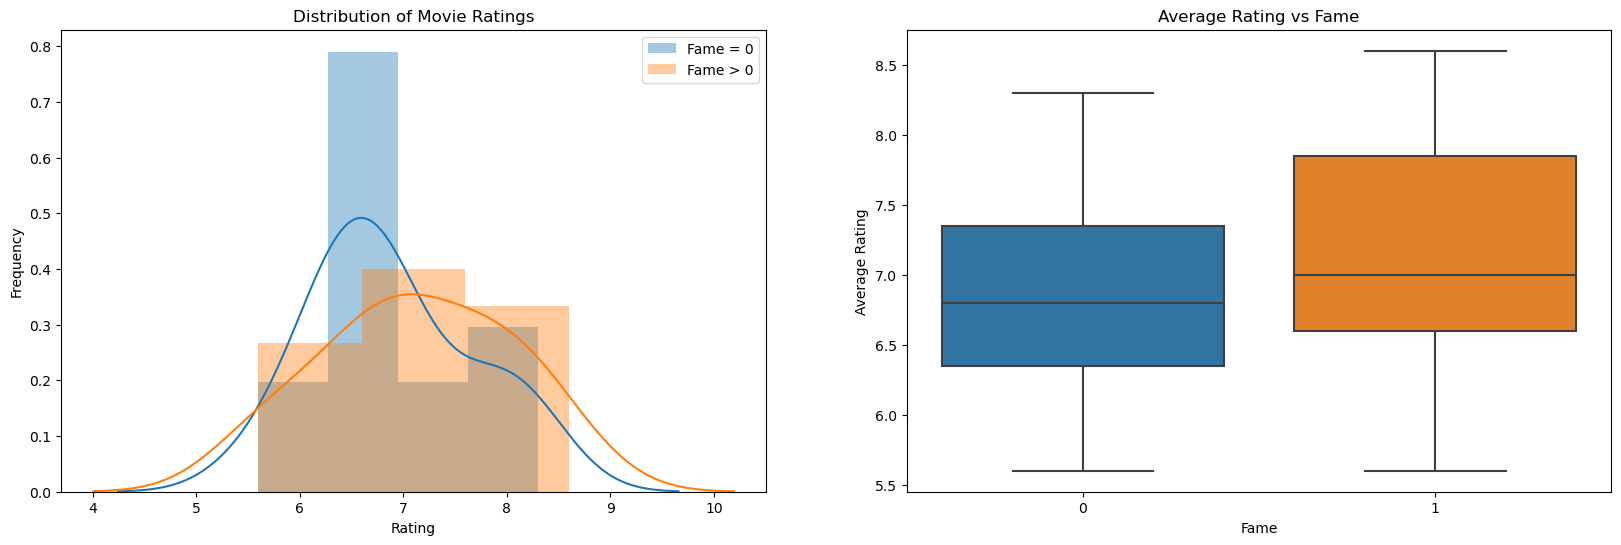

Paired t-test results:
t-statistic: -1.1286272611114843
p-value: 0.27802469912785666
The difference in means is not statistically significant.
The average rating for movies with fame = 0 is higher.


In [32]:

from scipy.stats import ttest_rel

# plot the ratings distribution for the two groups with two subplots one for displots and another for boxplots
plt.figure(figsize=(20,6))
plt.subplot(1,2,1)
sns.distplot(df_zero['averageRating'], label='Fame = 0')
sns.distplot(df_positive['averageRating'], label='Fame > 0')
plt.title('Distribution of Movie Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.legend()
plt.subplot(1,2,2)
sns.boxplot(x='fame_dummy', y='averageRating', data=matched_pairs)
plt.title('Average Rating vs Fame')
plt.xlabel('Fame')
plt.ylabel('Average Rating')
plt.show()

# Extract the ratings for the two groups
ratings_zero = df_zero['averageRating']
ratings_positive = df_positive['averageRating']

# Perform the paired t-test
t_statistic, p_value = ttest_rel(ratings_zero, ratings_positive)

# Print the results
print("Paired t-test results:")
print("t-statistic:", t_statistic)
print("p-value:", p_value)

# Check if the difference in means is statistically significant
if p_value < 0.05:
    print("The difference in means is statistically significant.")
else:
    print("The difference in means is not statistically significant.")

# interpret the results of the t-test
if t_statistic < 0:
    print("The average rating for movies with fame = 0 is higher.")
else:
    print("The average rating for movies with fame > 0 is higher.")


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


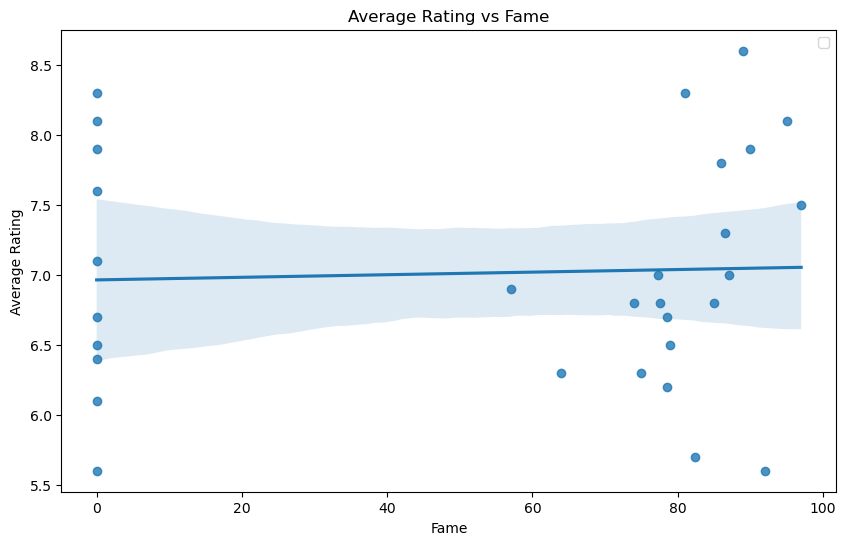

In [33]:
#regression of ratings vs fame for movies
plt.figure(figsize=(10,6))
# Create a scatterplot with a regression line
sns.regplot(x='fame_only', y='averageRating', data=matched_pairs)
plt.title('Average Rating vs Fame')
plt.xlabel('Fame')
plt.ylabel('Average Rating')
plt.legend()


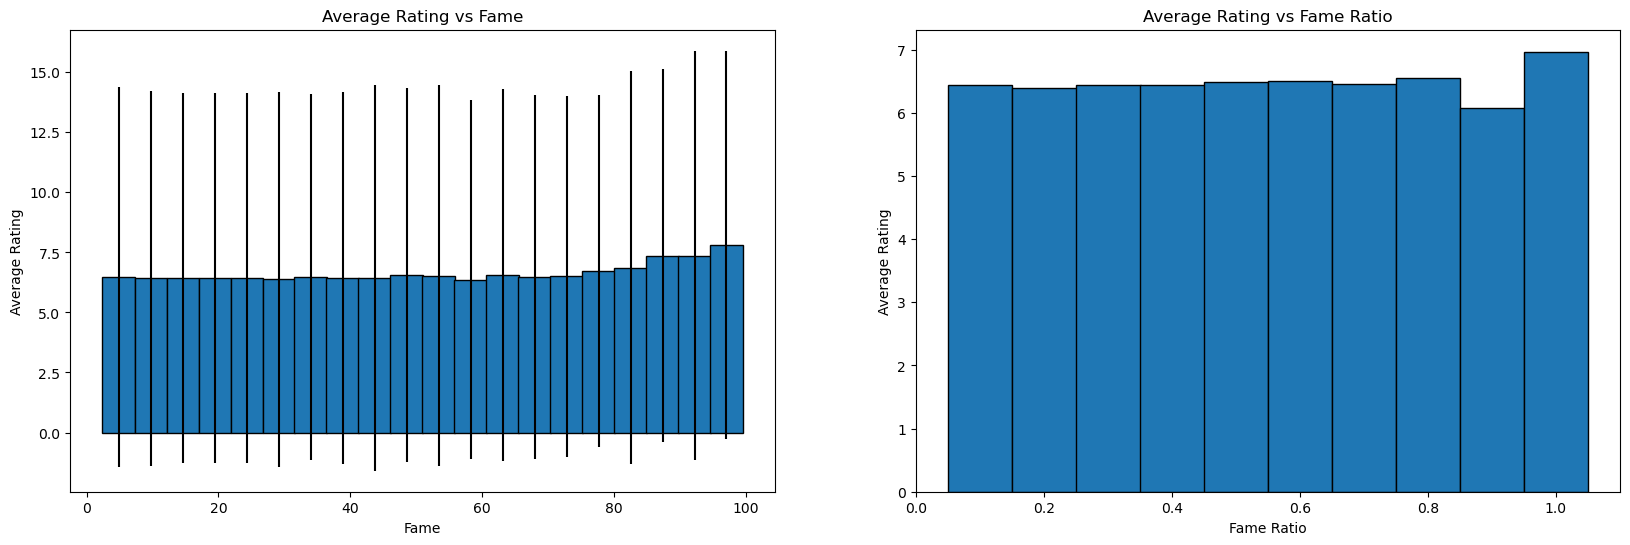

In [34]:
movies_fame = movies_copy.copy()
# plot the average rating over movies with fame in bins
plt.figure(figsize=(20,6))

# Calculate the mean of 'averageRating' for each bin
bin_means = movies_fame.groupby(pd.cut(movies_fame['Fame'], bins=20))['averageRating'].mean()
bin_midpoints = [(bin.left + bin.right) / 2 for bin in bin_means.index]
bin_width = bin_means.index[1].left - bin_means.index[0].left
bin_95 = movies_fame.groupby(pd.cut(movies_fame['Fame'], bins=20))['averageRating'].quantile(0.95)
plt.subplot(1,2,1)
plt.bar(bin_midpoints, bin_means.values, edgecolor='black', align='edge', width=bin_width, yerr=bin_95.values)
plt.title('Average Rating vs Fame')
plt.xlabel('Fame')
plt.ylabel('Average Rating')
plt.subplot(1,2,2)
#plot the average rating over movies with ratio in bins
# Calculate the mean of 'averageRating' for each bin
bin_means = movies_fame.groupby(pd.cut(movies_fame['fame_ratio'], bins=10))['averageRating'].mean()
bin_midpoints = [(bin.left + bin.right) / 2 for bin in bin_means.index]
bin_width = bin_means.index[1].left - bin_means.index[0].left
plt.bar(bin_midpoints, bin_means.values, edgecolor='black', align='edge', width=bin_width)
plt.title('Average Rating vs Fame Ratio')
plt.xlabel('Fame Ratio')
plt.ylabel('Average Rating')
plt.show()



Theory, only high levels of fame have an impact, above 75%, and ratio itself doesn't have an impact.

In [35]:
import ipywidgets as widgets
from IPython.display import display
import plotly.express as px
import plotly.graph_objects as go

def vis_cum(threshold):
    
    m = movies_fame[movies_fame['Fame'] > threshold]
    if threshold > 70 and threshold < 80:
        b = 10
    elif threshold >= 80 and threshold < 90:
        b = 5
    else:
        b = 20
    # Calculate the mean of 'averageRating' for each bin
    bin_means = m.groupby(pd.cut(m['Fame'], bins=b))['averageRating'].mean()
    bin_midpoints = [(bin.left + bin.right) / 2 for bin in bin_means.index]
    bin_width = bin_means.index[1].left - bin_means.index[0].left
    plt.figure(figsize=(20,6))
    plt.subplot(1,4,1)
    plt.plot(bin_midpoints, bin_means.values, 'o-', color='blue')
    #m.groupby(pd.cut(m['Fame'], bins=b))['averageRating'].mean().plot()
    #plt.bar(bin_midpoints, bin_means.values, edgecolor='black', align='edge', width=bin_width)
    plt.title('Average Rating vs Fame')
    plt.xlabel('Fame')
    plt.ylabel('Average Rating')
    plt.subplot(1,4,2)
    m.groupby('year_release')['Fame'].count().plot()
    plt.title('Number of Movies with Fame > ' + str(threshold) + ' per Year')
    plt.xlabel('Year')
    plt.ylabel('Number of Movies')
    plt.subplot(1,4,3)
    m.groupby('year_release')['Fame'].mean().plot()
    plt.title('Average Fame per Year')
    plt.xlabel('Year')
    plt.ylabel('Average Fame')
    plt.subplot(1,4,4)
    movies_fame.groupby('year_release')['averageRating'].mean().plot()
    plt.title('Average Rating per Year')
    plt.xlabel('Year')
    plt.ylabel('Average Rating')
    plt.show()

#TODO use plotly and add CI at 95% for the average rating, average fame and number of movies per year


widgets.interact(vis_cum, threshold=widgets.IntSlider(min=0, max=96, step=1, value=0))


interactive(children=(IntSlider(value=0, description='threshold', max=96), Output()), _dom_classes=('widget-in…

<function __main__.vis_cum(threshold)>

In [36]:
widgets.interact(vis_num, t=widgets.IntSlider(min=0, max=96, step=1, value=0))

interactive(children=(IntSlider(value=0, description='t', max=96), Output()), _dom_classes=('widget-interact',…

<function __main__.vis_num(t)>

In [37]:
# TODO see if year difference changes

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.linear_model import LogisticRegression
from causalml.match import NearestNeighborMatch 
from scipy.stats import ttest_rel

def pair_matching(threshold):    
    movies_reg = movies_copy.copy()

    # Flatten the lists of countries and get the top N most frequent countries
    top_countries = movies_reg['countries'].explode().value_counts().nlargest(10).index
    movies_reg['countries'] = movies_reg['countries'].apply(lambda lst: ['Other' if country not in top_countries else country for country in lst])

    # Initialize the MultiLabelBinarizer
    mlb = MultiLabelBinarizer()

    # Fit and transform the lists of countries
    one_hot_encoded = mlb.fit_transform(movies_reg['countries'])

    # Create a DataFrame with the one-hot encoded values
    one_hot_df = pd.DataFrame(one_hot_encoded, columns=mlb.classes_)

    # Concatenate the original DataFrame with the one-hot encoded DataFrame
    movies_reg = pd.concat([movies_reg, one_hot_df], axis=1)

    # do the same for the languages
    top_languages = movies_reg['languages'].explode().value_counts().nlargest(10).index
    movies_reg['languages'] = movies_reg['languages'].apply(lambda lst: ['Other' if language not in top_languages else language for language in lst])

    # Initialize the MultiLabelBinarizer
    mlb = MultiLabelBinarizer()
    # Fit and transform the lists of languages
    one_hot_encoded = mlb.fit_transform(movies_reg['languages'])
    # Create a DataFrame with the one-hot encoded values
    one_hot_df = pd.DataFrame(one_hot_encoded, columns=mlb.classes_)
    # Concatenate the original DataFrame with the one-hot encoded DataFrame
    movies_reg = pd.concat([movies_reg, one_hot_df], axis=1)

    # do the same for the genres
    top_genres = movies_reg['genres'].explode().value_counts().nlargest(10).index
    movies_reg['genres'] = movies_reg['genres'].apply(lambda lst: ['Other' if genre not in top_genres else genre for genre in lst])
    # Initialize the MultiLabelBinarizer
    mlb = MultiLabelBinarizer()
    # Fit and transform the lists of genres
    one_hot_encoded = mlb.fit_transform(movies_reg['genres'])
    # Create a DataFrame with the one-hot encoded values
    one_hot_df = pd.DataFrame(one_hot_encoded, columns=mlb.classes_)
    # Concatenate the original DataFrame with the one-hot encoded DataFrame
    movies_reg = pd.concat([movies_reg, one_hot_df], axis=1)

    pd.set_option('display.max_columns', None)


    #replace the NaN values with 0
    movies_reg = movies_reg.fillna(0)

    #create a new column with a dummy variable if fame > threshold
    movies_reg['fame_dummy'] = movies_reg['Fame'].apply(lambda x: 1 if x > threshold else 0)


    # Select the relevant features for the logistic regression model, and all the one-hot encoded columns
    # features when using all the the movies
    #features = ['numVotes', 'award_cumcount', 'movies_cumcount', 'num_actors', 'Australia', 'Canada', 'France', 'Germany', 'India', 'Italy', 'Japan', 'Other', 'South Korea', 'United Kingdom', 'United States of America', 'English Language', 'French Language', 'German Language', 'Hindi Language', 'Italian Language', 'Japanese Language', 'Korean Language', 'Other', 'Silent film', 'Spanish Language', 'Standard Mandarin', 'Action', 'Black-and-white', 'Comedy', 'Crime Fiction', 'Drama', 'Indie', 'Other', 'Romance Film', 'Short Film', 'Thriller', 'World cinema']
    # features when using only the movies with numVotes >= 2000
    features = ['numVotes', 'award_cumcount', 'movies_cumcount', 'num_actors', 'Australia', 'Canada', 'France', 'Germany', 'India', 'Italy', 'Japan', 'Other', 'Spain', 'United Kingdom', 'United States of America', 'English Language', 'French Language', 'German Language', 'Hindi Language', 'Italian Language', 'Japanese Language', 'Russian Language', 'Other', 'Swedish Language', 'Spanish Language', 'Standard Mandarin', 'Action', 'Action/Adventure', 'Comedy', 'Crime Fiction', 'Drama', 'Indie', 'Other', 'Romance Film', 'Horror', 'Thriller', 'World cinema']

    # Create the feature matrix X and the target variable y
    X = movies_reg[features]
    y = movies_reg['fame_dummy']

    # Fit the logistic regression model
    model = LogisticRegression()
    model.fit(X, y)

    # Compute the propensity scores
    propensity_scores = model.predict_proba(X)[:, 1]

    # Add the propensity scores to the movies_copy dataset
    movies_copy['propensity_score'] = propensity_scores


    # add dummy variable for fame_only >0 in the movies_copy dataframe
    movies_copy['fame_dummy'] = movies_reg['fame_dummy']

    # Initialize Matching
    matcher = NearestNeighborMatch()

    #match the data with the propensity scores as the y column and use one element from each dataset to make a pair, use NearestNeighborMatch() to match the pairs
    matched_pairs = matcher.match(data=movies_copy, treatment_col='fame_dummy', score_cols=['propensity_score'])

    # make a dataframe with only the fame_dummy = 0 elements of the matched pairs
    df_zero = matched_pairs[matched_pairs['fame_dummy'] == 0]
    # make a dataframe with only the fame_dummy = 1 elements of the matched pairs
    df_positive = matched_pairs[matched_pairs['fame_dummy'] == 1]

    # check the number of elements in each dataframe
    print(len(df_zero))
    print(len(df_positive))



    # plot the ratings distribution for the two groups with two subplots one for displots and another for boxplots
    plt.figure(figsize=(20,6))
    plt.subplot(1,2,1)
    sns.distplot(df_zero['averageRating'], label='Fame = 0')
    sns.distplot(df_positive['averageRating'], label='Fame > 0')
    plt.title('Distribution of Movie Ratings')
    plt.xlabel('Rating')
    plt.ylabel('Frequency')
    plt.legend()
    plt.subplot(1,2,2)
    sns.boxplot(x='fame_dummy', y='averageRating', data=matched_pairs)
    plt.title('Average Rating vs Fame')
    plt.xlabel('Fame')
    plt.ylabel('Average Rating')
    plt.show()

    # Extract the ratings for the two groups
    ratings_zero = df_zero['averageRating']
    ratings_positive = df_positive['averageRating']

    # Perform the paired t-test
    t_statistic, p_value = ttest_rel(ratings_zero, ratings_positive)

    # Print the results
    print("Paired t-test results:")
    print("t-statistic:", t_statistic)
    print("p-value:", p_value)

    # Check if the difference in means is statistically significant
    if p_value < 0.05:
        print("The difference in means is statistically significant.")
    else:
        print("The difference in means is not statistically significant.")

    # interpret the results of the t-test
    if t_statistic < 0:
        print("The average rating for movies with fame = 0 is higher.")
    else:
        print("The average rating for movies with fame > 0 is higher.")




In [38]:
widgets.interact(pair_matching, threshold=widgets.IntSlider(min=0, max=96, step=1, value=0))

interactive(children=(IntSlider(value=0, description='threshold', max=96), Output()), _dom_classes=('widget-in…

<function __main__.pair_matching(threshold)>

<Axes: xlabel='Fame'>

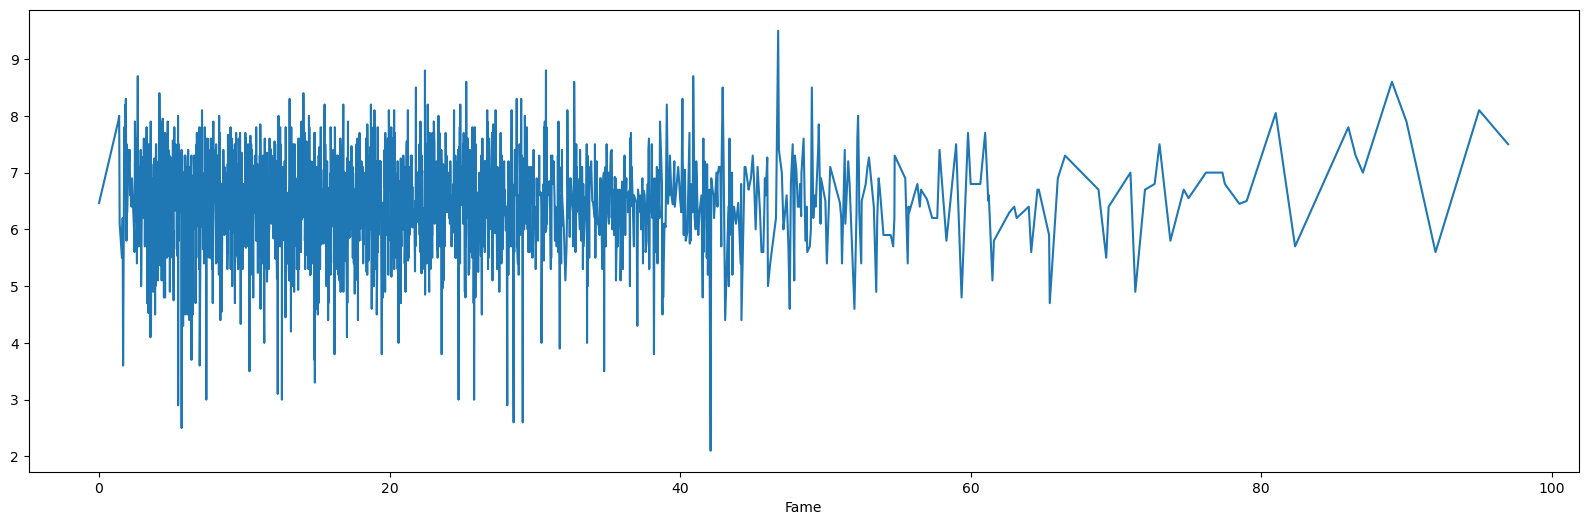

In [41]:
plt.figure(figsize=(20,6))
movies_fame.groupby('Fame')['averageRating'].mean().plot()

analsysis

In [40]:
#TODO good and bad in only fame analysis

analysis done